# Импорты

In [1]:
from obspy import read
from matplotlib import pyplot as plt
import pandas as pd

import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from obspy.imaging.cm import pqlx
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

from obspy.core.inventory.inventory import Inventory
from obspy.core.inventory.network import Network
from obspy.core.inventory.station import Station
from obspy.core.inventory.channel import Channel
from obspy.core.inventory.util import Site

from obspy.io.mseed.util import get_record_information
from obspy.core.inventory.inventory import read_inventory

from obspy.signal.invsim import corn_freq_2_paz

from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import trigger_onset
from obspy.signal.trigger import z_detect
from obspy.signal.trigger import recursive_sta_lta

from obspy.core.inventory.response import Response

%load_ext autoreload
%autoreload 2
import seismosocialdistancing

# Константы

In [2]:
sensitivity = 14.28 # В/м 

station = "3392" # Станция
path1 = f".\\010 - Source\\*{station}*\*" # Путь к минисидам
dataset = f"{station}_Proc" # Префикс для сохранения
channel_proc = "EQZ" # Обрабатываемый канал

# Отклик акселерометра

In [3]:
a = 0.4142212012175968
b = 0
paz_1hz = corn_freq_2_paz(0.1, damp=0.707)
paz_1hz['gain'] = 1
paz_1hz['sensitivity'] = 1/sensitivity
# paz_1hz['poles'] = [(-a-b*1j), (-a+b*1j)]
# paz_1hz['zeros'] = [0j, 0j, 0j]
paz_1hz['stage_gain'] = 1
paz_1hz

{'poles': [(-0.4442212012175968-0.44435537628385885j),
  (-0.4442212012175968+0.44435537628385885j)],
 'zeros': [0j, 0j],
 'gain': 1,
 'sensitivity': 0.0700280112044818,
 'stage_gain': 1}

In [4]:
resp = Response.from_paz(zeros=paz_1hz["zeros"], poles=paz_1hz["poles"], stage_gain=1, input_units='M/S')
resp

Channel Response
	From M/S () to VOLTS ()
	Overall Sensitivity: 0.999953 defined at 1.000 Hz
	1 stages:
		Stage 1: PolesZerosResponseStage from M/S to VOLTS, gain: 1

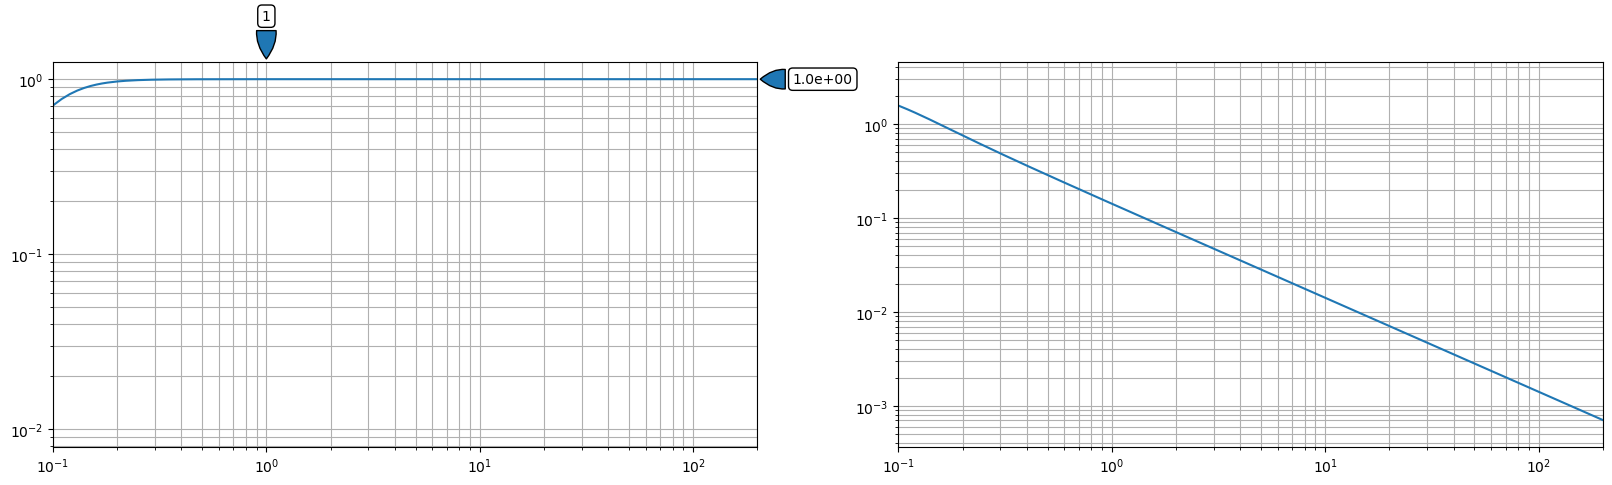

In [5]:
resp = Response.from_paz(zeros=paz_1hz["zeros"], poles=paz_1hz["poles"], stage_gain=paz_1hz['stage_gain'], input_units='M/S**2')
fig, axs = plt.subplots(1, 2, figsize=(20,5))

resp.plot(min_freq=0.01, output='ACC', sampling_rate=500, axes=[axs[0], axs[1]], show=False)
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.1, 200])
    # ax.set_ylim([0.5, 1.1])
    ax.grid(which='minor')
    ax.grid(which='major')
plt.show()

# Загрузка данных

In [6]:
files_wh = glob(path1)

In [7]:
st = read(path1).select(channel=channel_proc).sort(keys=['starttime'])
print(st.__str__(extended=True))

C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3392_33_EQZ_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3392_33_EQN_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3392_33_EQE_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: readMSEEDBuffer(): Last record only has 68 byte(s) which is not enough to constitute a full SEED record. Corrupt data? Record will be skipped.
  

380 Trace(s) in Stream:
D3.3392.33.EQZ | 2024-01-25T13:28:39.000000Z - 2024-01-25T13:58:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T13:49:43.000000Z - 2024-01-25T14:19:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T13:58:39.000000Z - 2024-01-25T14:28:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:19:43.000000Z - 2024-01-25T14:49:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:28:39.000000Z - 2024-01-25T14:58:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:49:43.000000Z - 2024-01-25T15:19:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:58:39.000000Z - 2024-01-25T15:28:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T15:19:43.000000Z - 2024-01-25T15:49:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T15:28:43.001000Z - 2024-01-25T15:58:38.999000Z | 500.0 Hz, 898000 samples
D3.3392.33.EQZ | 2024-01-25T15:49:46.000000Z - 2024-01-25T

# Удаление коротышей

In [8]:
for tr in st:
    if len(tr.data)<100000:
        st.remove(tr)
print(st.__str__(extended=True))

380 Trace(s) in Stream:
D3.3392.33.EQZ | 2024-01-25T13:28:39.000000Z - 2024-01-25T13:58:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T13:49:43.000000Z - 2024-01-25T14:19:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T13:58:39.000000Z - 2024-01-25T14:28:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:19:43.000000Z - 2024-01-25T14:49:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:28:39.000000Z - 2024-01-25T14:58:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:49:43.000000Z - 2024-01-25T15:19:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T14:58:39.000000Z - 2024-01-25T15:28:38.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T15:19:43.000000Z - 2024-01-25T15:49:42.998000Z | 500.0 Hz, 900000 samples
D3.3392.33.EQZ | 2024-01-25T15:28:43.001000Z - 2024-01-25T15:58:38.999000Z | 500.0 Hz, 898000 samples
D3.3392.33.EQZ | 2024-01-25T15:49:46.000000Z - 2024-01-25T

# Тестирование подавления отклика

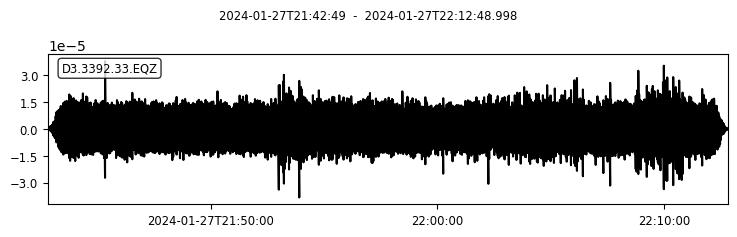

Sensetivity check - 18.397327479818426


In [9]:
paz_1hz = corn_freq_2_paz(0.1, damp=0.707)
paz_1hz['gain'] = 1
paz_1hz['sensitivity'] = 1/sensitivity

NN = 116
st_ed = st.copy()
st_ed[NN].simulate(paz_simulate=paz_1hz)
st_ed[NN].plot()

razm1 = (st[NN].data.max()-st[NN].data.min())
razm2 = (st_ed[NN].data.max()-st_ed[NN].data.min())

print("Sensetivity check -", razm1/razm2)

## До/после

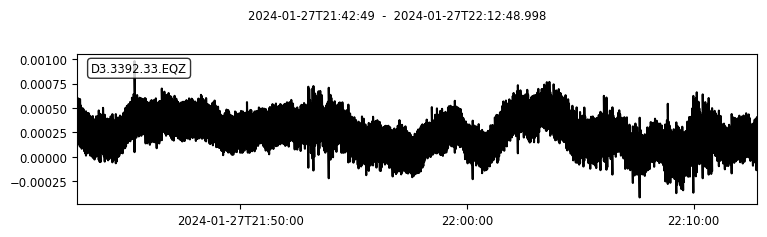

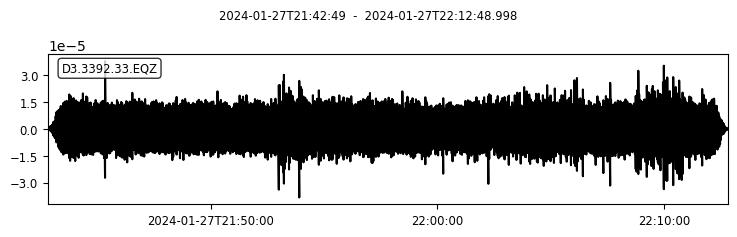

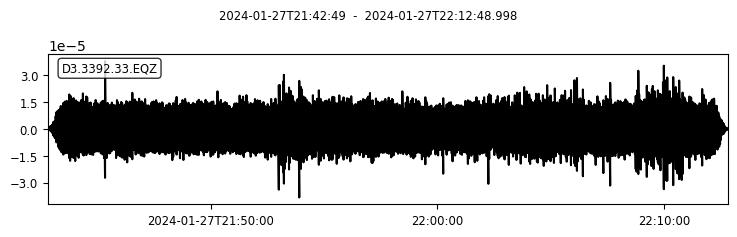

In [10]:
st[NN].plot()
st_ed[NN].plot()

## Dayplot до подавления отклика

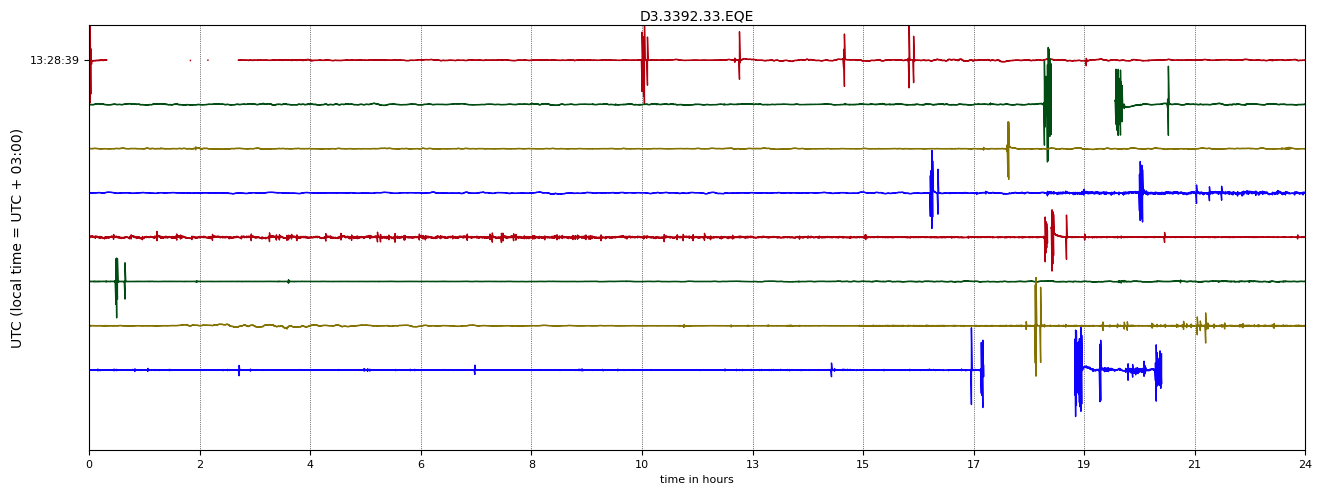

In [11]:
_ = st.plot(type='dayplot', interval=1440, size=(1600, 500))

## Удаление отклика во всем потоке

In [11]:
st = st.simulate(
    paz_simulate=paz_1hz,
)

## Dayplot после подавления отклика

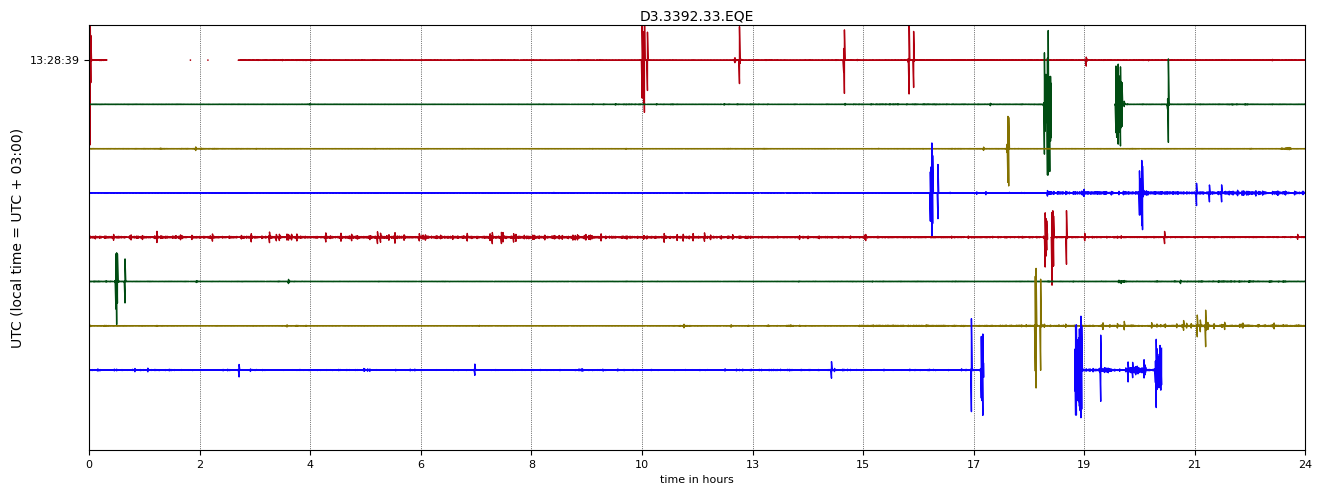

In [13]:
_ = st.plot(type='dayplot', interval=1440, size=(1600, 500))

# Удаление антропогенного шума

In [9]:
st_edit = st.copy()

In [10]:
st_z = st.copy()
z_win = int(40*df)
st_z.trigger('zdetect', nsta=z_win)

NameError: name 'df' is not defined

## Trigger methods

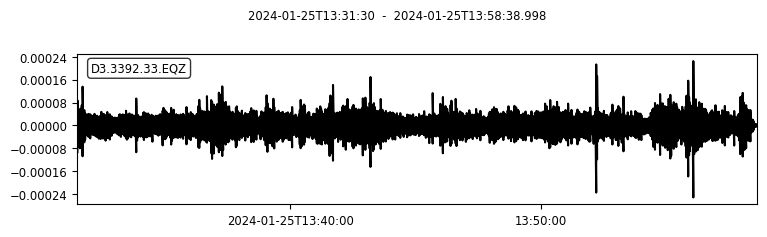

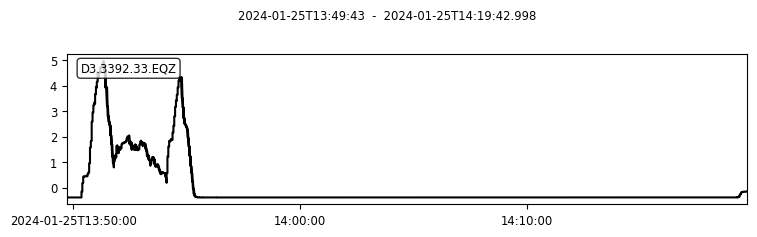

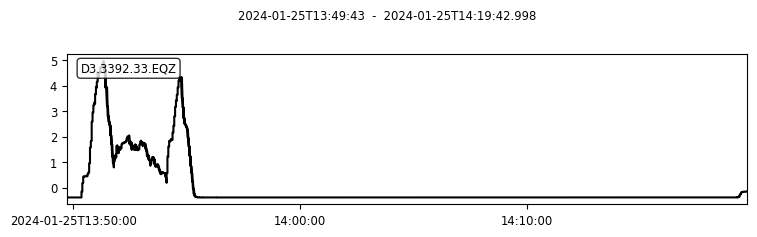

In [39]:
NN = 1
st_edit[NN].plot()
st_z[NN].plot()

In [38]:
t1 = st_z[0].stats.starttime
t2 = t1+2.85*60
st_edit.cutout(t1, t2)

381 Trace(s) in Stream:

D3.3392.33.EQZ | 2024-01-25T13:28:39.000000Z - 2024-01-25T13:28:39.000000Z | 500.0 Hz, 1 samples
...
(379 other traces)
...
D3.3392.33.EQZ | 2024-02-02T10:25:30.000000Z - 2024-02-02T10:38:25.134000Z | 500.0 Hz, 387568 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [14]:
lower_big = 1.5
upper_big = 0.5

df=st_z[0].stats.sampling_rate
z_win = int(200*df)

st_z.trigger('zdetect', nsta=z_win)
onsets = [trigger_onset(st_z_el.data, lower_big, upper_big, max_len=600*df, max_len_delete=True) for st_z_el in st_z]

for i, onset in enumerate(tqdm.tqdm(onsets)):
    for pair in onset:
        if st_z[i].data.min() > -0.7:
            p1 = pair[0] - z_win if pair[0] >= z_win else 0
            p2 = pair[1] + z_win if pair[1] <= len(st_z[i].data) - z_win else len(st_z[i].data)
            t1 = st_z[i].stats.starttime+p1/df
            t2 = st_z[i].stats.starttime+p2/df
            st_edit.cutout(t1, t2)

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:05<00:00, 74.61it/s]


## Dayplot после подавления антропогенных помех

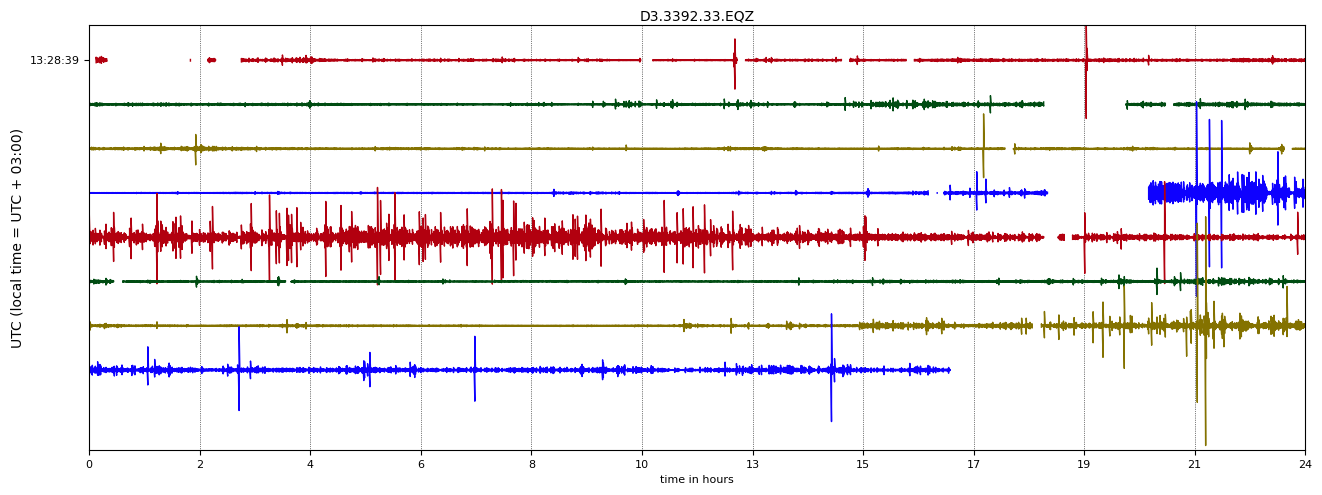

In [17]:
_ = st_edit[0:-6].plot(type='dayplot', interval=1440, size=(1600, 500))
# _ = st_edit[0:].plot(type='dayplot', interval=1440, size=(1600, 500))

## Ручное удаление (опционально!)

In [15]:
import pickle
f = open("3392 gaps.pickle", 'rb')
gaps = pickle.load(f)
f.close()
print(gaps[0][0])

2024-01-25T13:28:39.000000Z


In [16]:
for t1, t2 in gaps:
    st_edit.cutout(t1, t2)

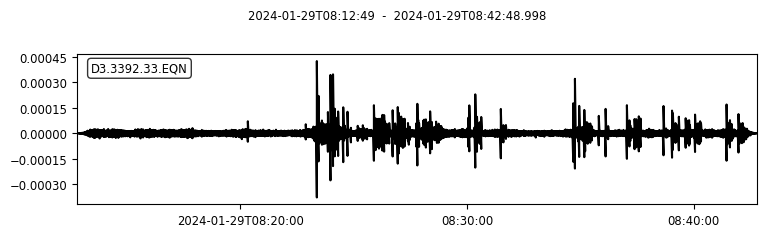

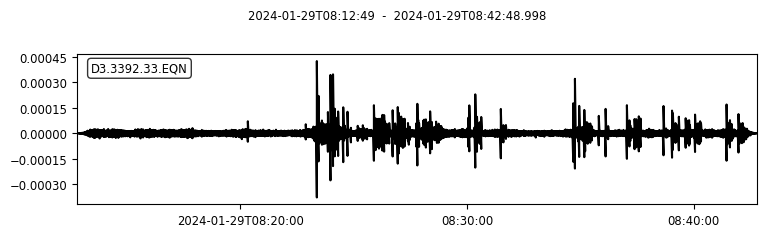

In [57]:
NN = 196
st_edit[NN].plot(show=True)

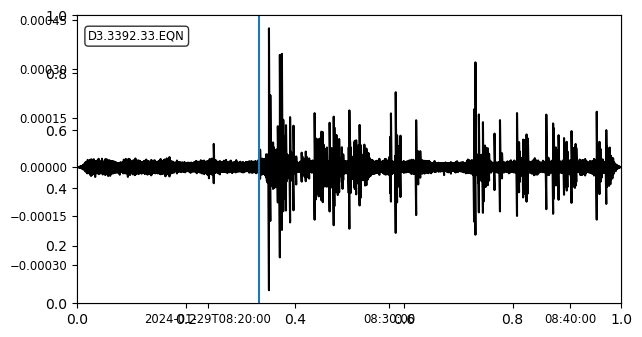

In [59]:
fig, axs = plt.subplots(1, 1, )
st_edit[NN].plot(show=True, fig=fig)
t1 = st_edit[NN].stats.starttime+10*60
plt.gca().axvline(t1)
plt.show()

In [60]:
t1 = st_edit[NN].stats.starttime+10*60
# t2 = st_edit[NN].stats.starttime+4*60
t2 = st_edit[NN].stats.endtime
st_edit.cutout(t1, t2)

400 Trace(s) in Stream:

D3.3392.33.EQN | 2024-01-25T13:28:39.000000Z - 2024-01-25T13:28:39.000000Z | 500.0 Hz, 1 samples
...
(398 other traces)
...
D3.3392.33.EQN | 2024-02-02T10:25:30.000000Z - 2024-02-02T10:38:25.134000Z | 500.0 Hz, 387568 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [78]:
NN = 198
st_edit.remove(st_edit[NN])

396 Trace(s) in Stream:

D3.3392.33.EQN | 2024-01-25T13:28:39.000000Z - 2024-01-25T13:28:39.000000Z | 500.0 Hz, 1 samples
...
(394 other traces)
...
D3.3392.33.EQN | 2024-02-02T10:25:30.000000Z - 2024-02-02T10:38:25.134000Z | 500.0 Hz, 387568 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# Построение PPSD

## Выделение нужной части потока

In [11]:
st_edit_fin = st_edit[:-6].copy()

In [12]:
datelist = pd.date_range(st_edit_fin[0].stats.starttime.datetime, st_edit_fin[-1].stats.endtime.datetime, freq="D")
datelist

DatetimeIndex(['2024-01-25 13:28:39', '2024-01-26 13:28:39',
               '2024-01-27 13:28:39', '2024-01-28 13:28:39',
               '2024-01-29 13:28:39', '2024-01-30 13:28:39',
               '2024-01-31 13:28:39', '2024-02-01 13:28:39'],
              dtype='datetime64[ns]', freq='D')

In [13]:
paz = {'gain': 1,
       'poles': [],
       'sensitivity': 1,
       'zeros': [],
       'stage_gain': 1}

## Расчет PPSD

In [ ]:
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_in = "{}_{}_{channel}.mseed".format(dataset, datestr, channel=channel_proc)
    pbar.set_description("Processing %s" % fn_in)
    fn_out = "{}_{}_{channel}.npz".format(dataset, datestr, channel=channel_proc)
    st_buff = st_edit_fin.slice(starttime=UTCDateTime(day)-1801,
                   endtime=UTCDateTime(day)+86400+1801,
                  )
    ppsd = PPSD(st_edit_fin[0].stats,
                paz, # Здесь используется плоский response, потому что он был удален ранее, на этапе обработки
                # paz_1hz,
                ppsd_length=1800,
                overlap=0,
                period_limits=(0.01, 100),
                db_bins=(-200, 20, 0.25),
                skip_on_gaps=True,
                special_handling='ringlaser',
               )
    ppsd.add(st_buff)
    ppsd.save_npz(fn_out[:-4])
    del st_buff, ppsd

## Загрузка PPSD

In [19]:
ppsds = {}
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_pattern = "{}_{}_{channel}.npz".format(dataset, datestr, channel=channel_proc)
    pbar.set_description("Reading %s" % fn_pattern)
    for fn in glob(fn_pattern):
        mseedid = f"{station} " + fn.replace(".npz", "").split("_")[-1]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn)#, allow_pickle=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ppsds[mseedid].add_npz(fn)#, allow_pickle=True)

Reading 3392_Proc_2024-02-01_EQZ.npz: 100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 149.78it/s]


In [20]:
# import pickle
# f = open("3392 gaps.pickle", 'wb')
# pickle.dump(ppsds["3392 EQN"].times_gaps, f)
# f.close()

# Построение графиков

In [21]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

In [31]:
ppsd = [ppsd for mseedid, ppsd in ppsds.items()][0]

## График RMS смещений с процентилями

In [32]:
import seaborn as sns

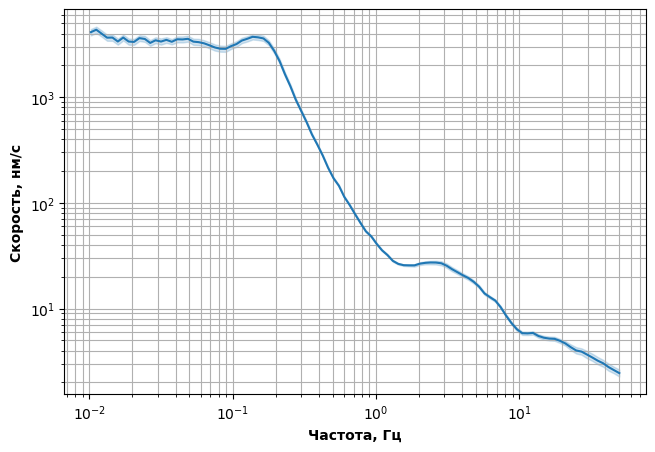

In [77]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 5))

freqs = [(0.01, 50.)]

ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
data = data.sort_index(axis=1)
data = data.dropna(axis=1, how='all')

fmin, fmax = freqs[0]
ix = np.where((data.columns>=fmin) & (data.columns<=fmax))[0]
spec = data.iloc[:,ix]
f = data.columns[ix]

w2f = (2.0 * np.pi * f)

# w2f = 2.0 * np.pi * (1./ppsd.period_bin_centers)
# w2f = w2f[::-1]

# The acceleration power spectrum (dB to Power! = divide by 10 and not 20!)
amp = 10.0**(spec/10.) 
vamp = amp / w2f**2
damp = vamp / w2f**2

amp = amp.transpose().stack().reset_index()
amp.columns = ['f','datetime','amp']

damp = damp.transpose().stack().reset_index()
damp.columns = ['f','datetime','damp']

vamp = np.sqrt(1e18*vamp).transpose().stack().reset_index()
vamp.columns = ['f','datetime','vamp']

# sns.lineplot(vamp, x='f', y='vamp', units="datetime", legend=False, ax=axs, estimator=None)
sns.lineplot(vamp, x='f', y='vamp', legend=False, ax=axs)
axs.set_xscale('log')
axs.set_yscale('log')
axs.grid(which='minor')
axs.grid()
axs.set_xlabel("Частота, Гц", fontweight='bold')
axs.set_ylabel("Скорость, нм/с", fontweight='bold')



plt.show()

In [34]:
spec

,0.010265,0.011194,0.012207,0.013312,0.014517,0.015831,0.017263,0.018826,0.020530,0.022388,...,42.044821,45.850202,50.000000,54.525387,59.460356,64.841978,70.710678,77.110541,84.089642,91.700404
2024-01-25 14:19:43,-121.178474,-119.988121,-119.988121,-119.988121,-119.618019,-119.618019,-119.177254,-119.177254,-119.918907,-120.858727,...,-115.777931,-114.699455,-113.683884,-113.084435,-112.752541,-112.840515,-113.304527,-114.050156,-115.248535,-117.071068
2024-01-25 14:49:43,-135.350266,-133.926208,-133.926208,-133.926208,-132.263168,-132.263168,-129.901199,-129.901199,-129.312836,-127.288078,...,-116.623260,-115.556091,-114.548416,-113.951424,-113.646240,-113.774170,-114.252869,-115.119865,-116.499886,-118.442993
2024-01-25 16:28:39,-135.616211,-136.231537,-136.231537,-136.231537,-135.565567,-135.565567,-134.347580,-134.347580,-133.405106,-132.258942,...,-124.336082,-124.242073,-124.062805,-124.342430,-124.665306,-125.454063,-126.376938,-127.477219,-128.603012,-129.800720
2024-01-25 16:58:39,-136.257431,-137.133072,-137.133072,-137.133072,-136.172440,-136.172440,-134.445892,-134.445892,-133.803146,-132.033707,...,-124.137642,-123.861343,-123.460907,-123.610344,-123.847855,-124.516312,-125.369751,-126.532326,-127.716164,-129.037476
2024-01-25 17:28:39,-126.092522,-124.897568,-124.897568,-124.897568,-124.761528,-124.761528,-125.348663,-125.348663,-125.417946,-125.967209,...,-121.602570,-121.185326,-120.746674,-120.581650,-120.484779,-120.684456,-121.050339,-121.760757,-122.717667,-124.123299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02 03:28:38,-134.819702,-134.170914,-134.170914,-134.170914,-132.188019,-132.188019,-129.707550,-129.707550,-128.294144,-125.859901,...,-121.989288,-121.105354,-120.250336,-119.770027,-119.688515,-119.842903,-120.167465,-120.818275,-121.940353,-123.812706
2024-02-02 03:58:38,-135.339920,-133.191589,-133.191589,-133.191589,-131.669739,-131.669739,-128.708694,-128.708694,-127.068153,-124.257103,...,-117.524246,-116.623558,-115.786125,-115.345200,-114.992157,-114.827583,-114.938736,-115.439972,-116.627655,-118.644508
2024-02-02 04:28:38,-137.426605,-136.354660,-136.354660,-136.354660,-135.098694,-135.098694,-132.708313,-132.708313,-131.908218,-129.570084,...,-122.230774,-122.395386,-122.682823,-123.351830,-123.871857,-124.407242,-125.033577,-125.931091,-126.918777,-128.357239
2024-02-02 04:58:38,-139.169907,-136.423676,-136.423676,-136.423676,-135.299744,-135.299744,-133.085739,-133.085739,-132.620071,-131.197495,...,-123.650528,-123.836876,-124.298592,-125.258278,-125.862518,-126.433647,-127.200668,-128.238556,-129.284836,-130.638840


In [35]:
w.shape

NameError: name 'w' is not defined

# Список значений для таблички

In [36]:
for elem in np.array([w, 1e9*(w**2)*10**(perc90/10)]).T:
    print(elem)

NameError: name 'w' is not defined

## PPSD графики

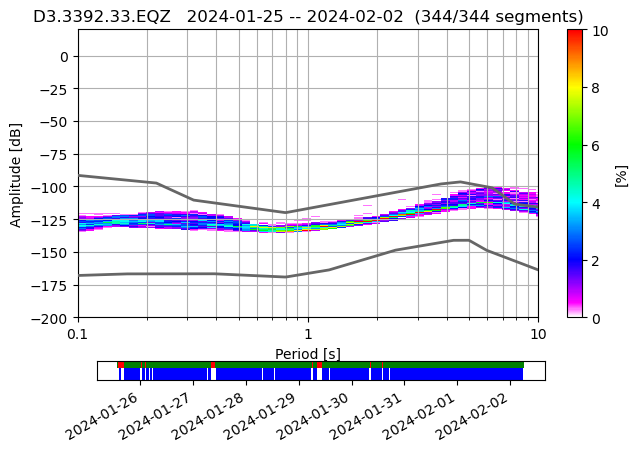

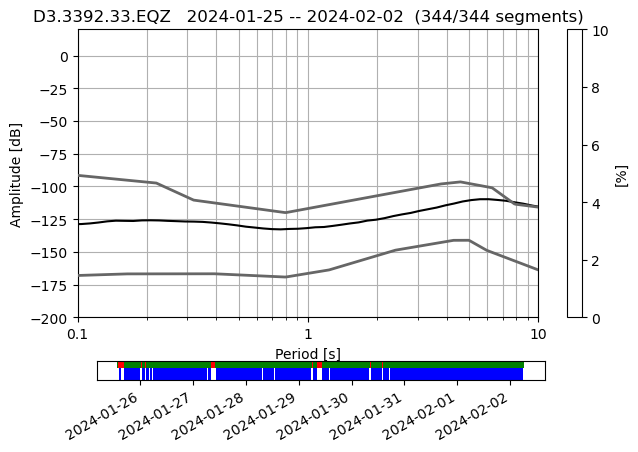

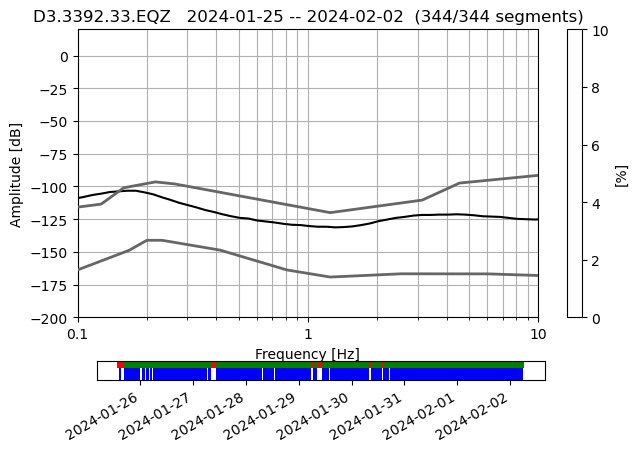

[None]

In [37]:
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), cmap=pqlx) for mseedid, ppsd in ppsds.items()]
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), show_mean=True, cmap=map_object) for mseedid, ppsd in ppsds.items()]
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), show_mean=False, cmap=map_object, show_percentiles=True, percentiles=[90], xaxis_frequency=True) for mseedid, ppsd in ppsds.items()]

# Другие графики, но пока что они не нужны

In [88]:
freqs = [(0.1,0.2),(0.2, 0.4),(0.4, 0.8),(0.8, 1.6), (1.6, 3.2), (3.2, 6.4), (6.4, 12.8), (0.1, 10), (1, 10)]
freqs_real = [(1,20.0)]
displacement_RMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
    data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
    data = data.sort_index(axis=1)
    displacement_RMS[mseedid] = seismosocialdistancing.df_rms(data, freqs, output="VEL", freqs_real=freqs_real)
    displacement_RMS[mseedid].to_csv("%s.csv" % mseedid)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


In [34]:
(1./ppsd.period_bin_centers).shape

(108,)

In [328]:
displacement_RMS["3388 EQZ"].loc[displacement_RMS["3388 EQZ"]["0.1-50.0"]>200*10e-10]=np.nan
# displacement_RMS["3388 EQZ"]["0.1-50.0"] = displacement_RMS["3388 EQZ"]["0.1-50.0"].rolling(3).median()
# displacement_RMS

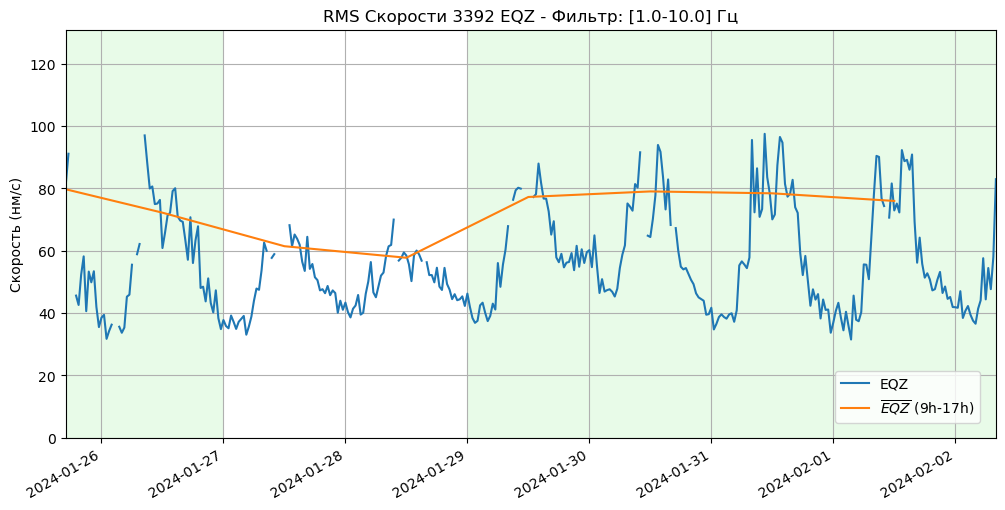

In [89]:
time_zone = "Europe/Moscow"
sitedesc = "in Moscow (Protvino, suburbian)"
# logo = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png'


args = {'band':"1.0-10.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'нм/с'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

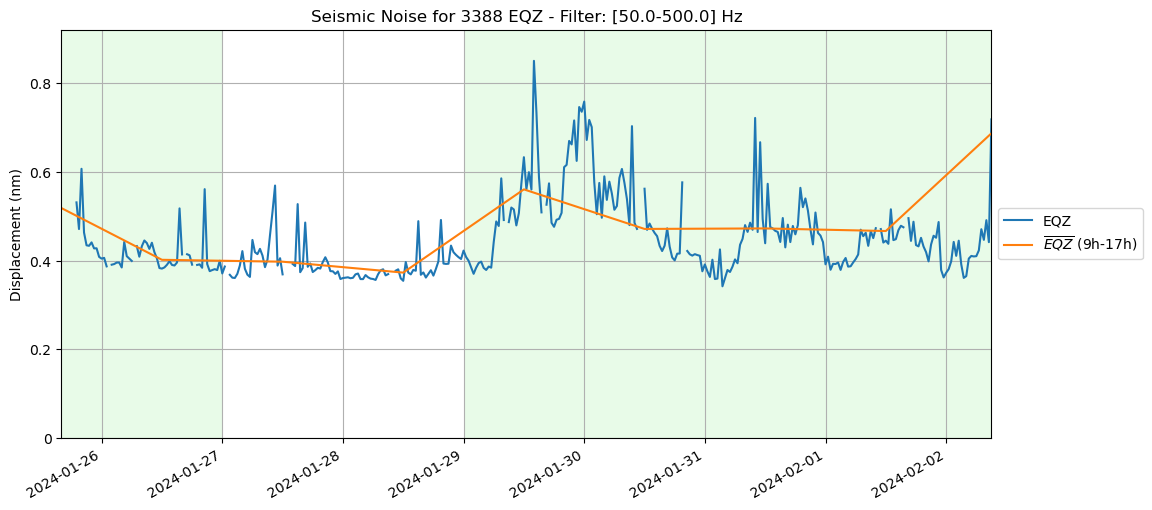

In [331]:
# displacement_RMS["EQZ"].loc[displacement_RMS["EQZ"]["50.0-600.0"]>2.5*10e-10]=np.nan
# displacement_RMS
time_zone = "Europe/Moscow"
sitedesc = "in Moscow (Protvino, suburbian)"
# logo = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png'


args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

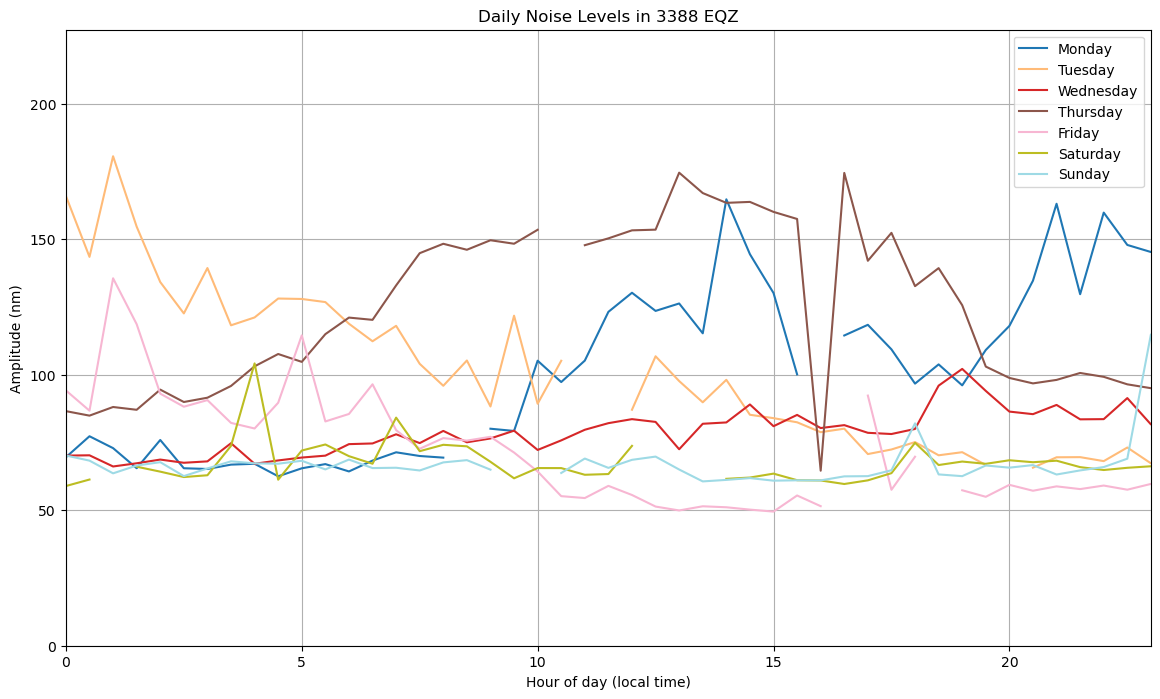

In [332]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='dailyplots',
                            **args)

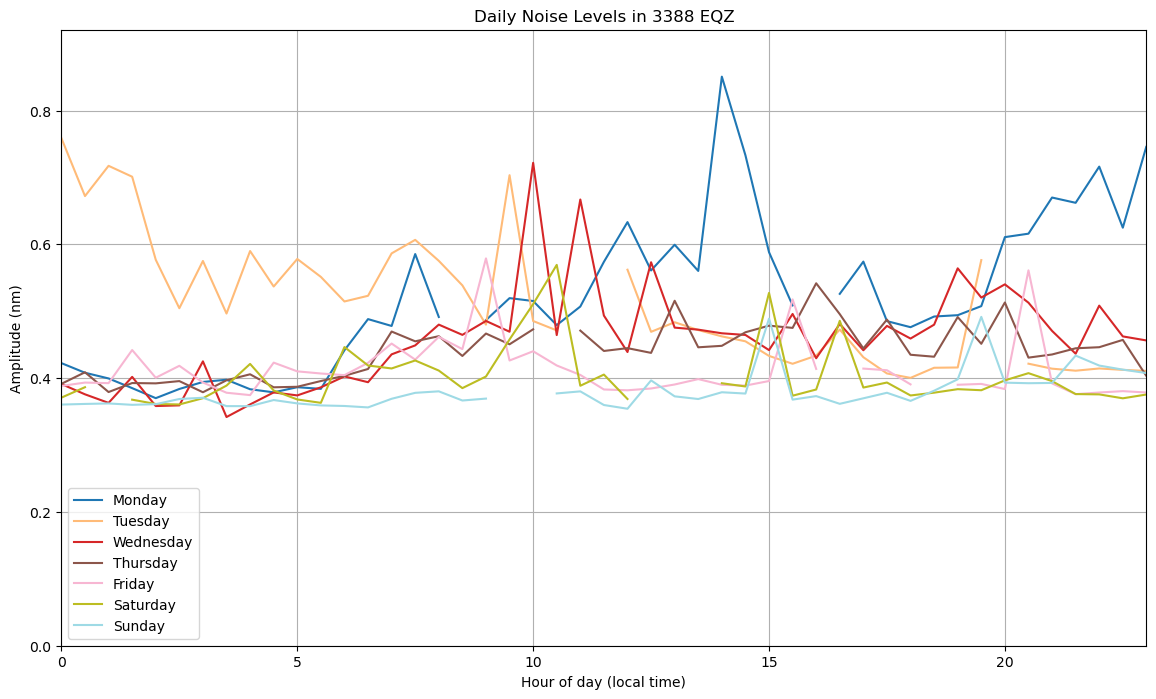

In [334]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='dailyplots',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


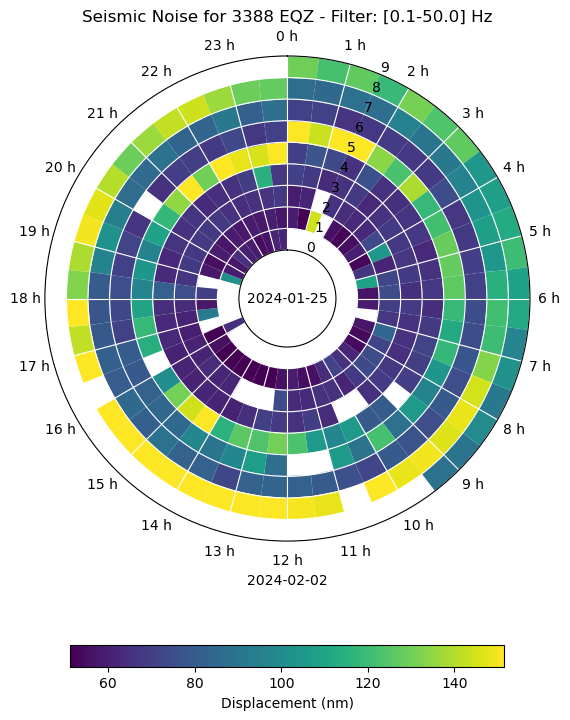

In [320]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


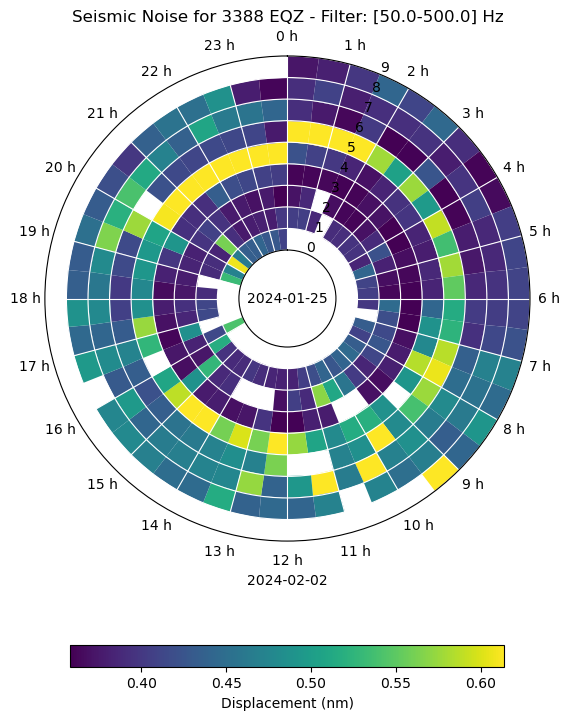

In [335]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


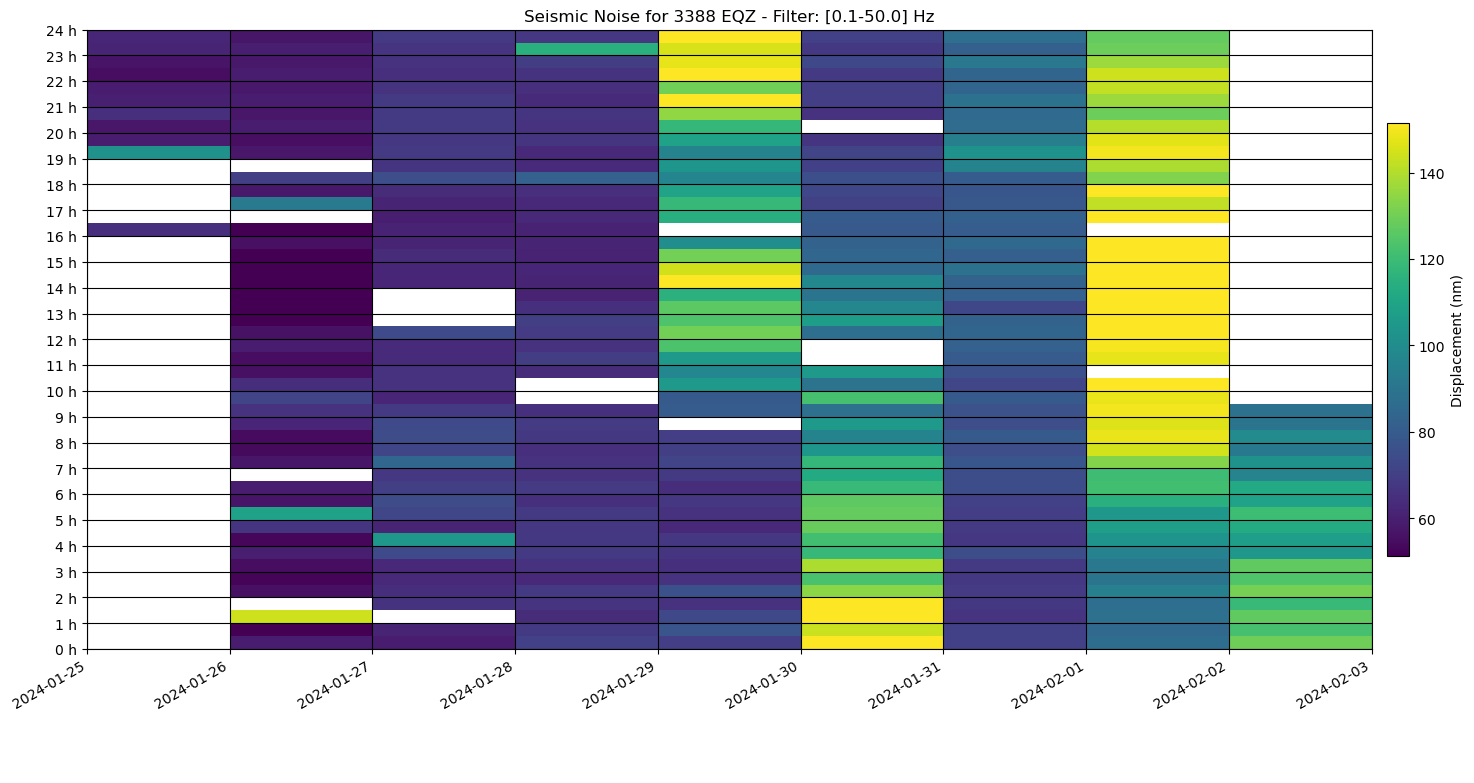

In [321]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


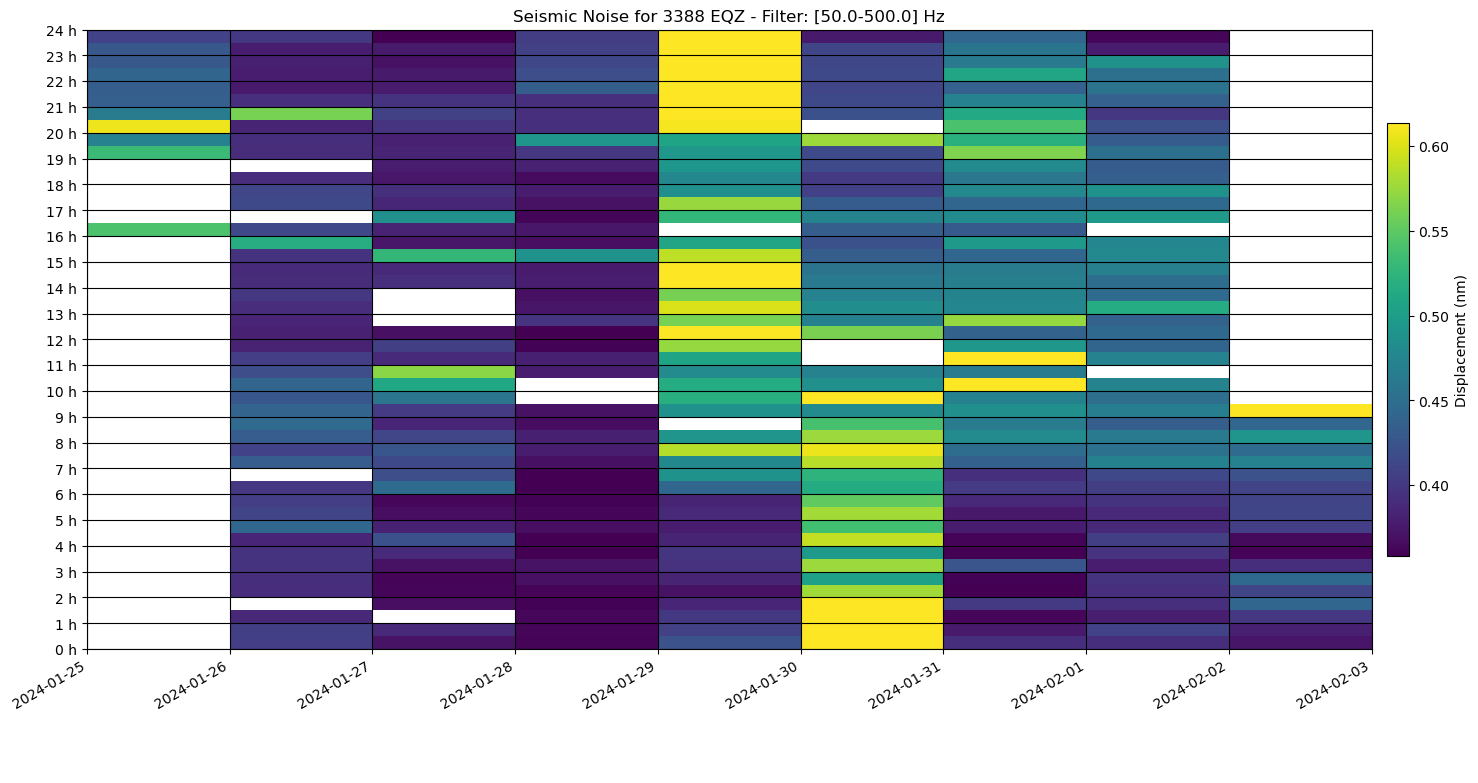

In [336]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)